XGBoost
==================
XGBoost
- 트리 기반의 앙상블 학습에서의 알고리즘 중 하나
- 병렬 CPU 환경에서 병렬 학습이 가능해 기존 GBM보다 빠르게 학습을 완료할 수 있음

XGBoost의 장점
1. 뛰어난 예측 성능
2. GBM 대비 빠른 수행 시간
  - GBM : weaker learner가 가중치를 증감하는 방식으로 학습 -> 속도가 느림 
3. 과적합 규제
4. Tree pruning
5. 자체 내장된 교차 검증
6. 결손값 자체 처리

XGBoost 파라미터

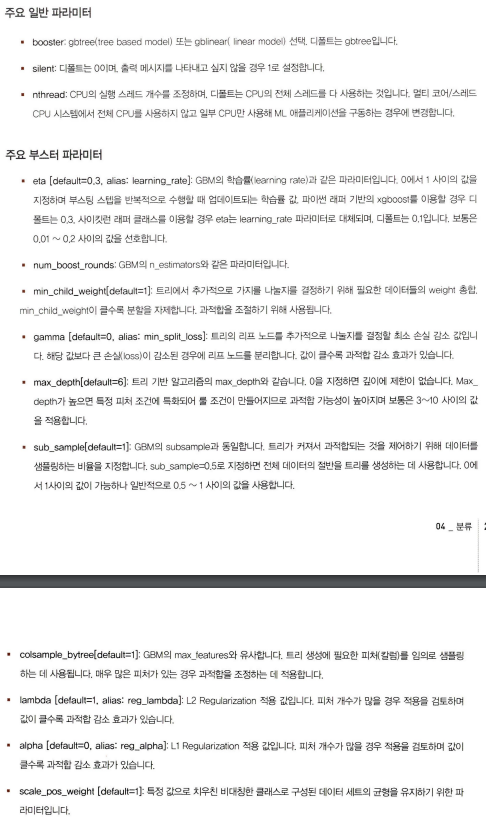

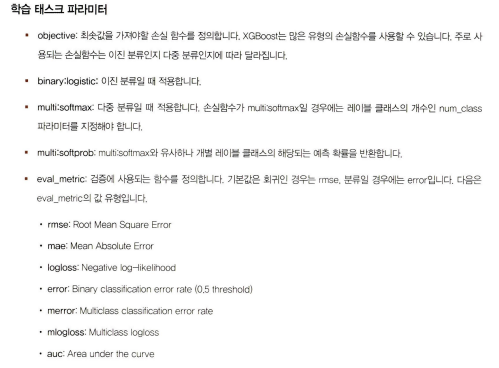

과적합 문제가 심각하면...
1. eta값 낮추기 / num_round(n_estimators) 높여주기
2. max_depth값 낮추기
3. min_child_weight값 높이기
4. gamma값 높이기
5. subsample, colsample_bytree 조정하기

조기 중단(early stopping) : 수행 속도를 향상시키기 위한 대표적 기능
- n_estimators에 지정한 부스팅 반복 횟수에 도달하지 않더라도 예측 오류가 더 이상 개선되지 않으면 반복을 끝까지 수행하지 않고 중지해 수행시간을 개선할 수 있음


In [ ]:
# pg.230 : xgboost 설치하기

import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
# pg.233 : xgboost 버전 확인하기

import xgboost
print(xgboost.__version__)

파이썬 래퍼 XGBoost 적용 - 위스콘신 유방암 예측
=====================================================
종양 : 양성 종양(benign) / 악성 종양(malignant)

plot_importance : 피처의 중요도를 시각화해주는 모듈


In [ ]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [ ]:
dataset=load_breast_cancer()
X_features = dataset.data
y_label = dataset.target
cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head(3)

- 많은 속성이 숫자형 값으로 되어 있음
- 악성 : 0 / 양성 : 1

In [ ]:
# 레이블 값의 분포 확인
print(dataset.target_names)
print(cancer_df['target'].value_counts())

In [ ]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, 
                                                  test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

In [ ]:
# DMatrix 변환 적용
dtrain=xgb.DMatrix(data = X_train, label = y_train)
dtest=xgb.DMatrix(data = X_test, label = y_test)

In [ ]:
#하이퍼 파라미터 설정하기

params={'max_depth':3,  
        'eta':0.1,  # learning rate
        'objective':'binary:logistic', # 이진 분류이기 때문에 목적함수는 이진 로지스틱  
        'eval_metric':'logloss',  # 오류 함수의 평가 성능 지표
        'early_stoppings':100 
        }
num_rounds = 400  # 부스팅 반복 횟수

- eval_set : 성능 평가를 수행할 평가용 데이터를 설정
- eval_metric : 평가 세트에 적용할 성능 평가 방법

- evals 파라미터에 학습 데이터 세트와 eval 데이터 세트를 명기해주면 평가를 eval 데이터 세트에 수행하면서 조기 중단을 적용할 수 있음
- 반복 시마다 evals에 표시된 데이터 세트에 대해 평가 지표 결과가 출력됨

In [ ]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval'로 명기
wlist = [(dtrain, 'train'), (dtest, 'eval')]

# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds, early_stopping_rounds=100, evals=wlist)

- train-error와 eval-logloss가 지속적으로 감소함


xgboost의 predict() : 예측 결괏값이 아닌 예측 결과를 추정할 수 있는 확률 값을 반환함
- 위 예제는 이진 분류이므로 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측 값을 결정하는 로직을 추가하기

In [ ]:
pred_probs=xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds=[1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [ ]:
# 모델의 예측 성능 평가
get_clf_eval(y_test, preds, pred_probs)

In [ ]:
# 시각화 기능 수행 : f0은 첫번째 피처, f1은 두번째 피처 의미

from xgboost import plot_importance   # xgboost의 plot_importance() : 피처의 중요도를 막대 그래프 형식으로 나타냄 
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax=plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax) 

- 트리 기반 규칙 구조도 xgboost에서 시각화할 수 있음
- xgboost의 to_graphviz() : 규칙 트리 구조 그릴 수 있음


In [ ]:
# pg.240 : xgboost에서 교차 검증 수행 후 최적의 파라미터 구하는 법 : cv()

xgboost.cv(params, dtrain, num_boost_round=10, nfold=3, stratified=False, folds=None, metrics=(), obj=None,
           feval=None, maximize=False, early_stopping_rounds=None, fpreproc=None, as_pandas=True, verbose_eval=None,
           show_stdv=True, seed=0, callbacks=None, shuffle=True)

- params : 부스트 파라미터
- dtrain : 학습 데이터
- num_boost_round : 부스팅 반복 횟수
- nfold : CV 폴드 개수
- stratified : CV 수행 시 층화 표본 추출 수행 여부
- metrics : CV 수행 시 표본 추출 수행 여부
- early_stopping_rounds : 조기 중단을 활성화시킴, 반복 횟수 지정

사이킷런 래퍼 XGBoost의 개요 및 적용
========================================
파이썬 래퍼 XGBoost의 하이퍼 파라미터 변경하기
- eta -> learning_rate
- sub_sample -> subsample
- lambda -> reg_lambda
- alpha -> reg_alpha

In [ ]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

In [ ]:
# 모델의 예측 성능 평가
get_clf_eval(y_test, w_preds, w_pred_proba)

파이썬 래퍼 XGBoost와 동일한 평가 결과

In [ ]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)
ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

n_estimators를 400으로 설정해도 311번 반복한 후 학습이 완료됨
- 211번~311번 early_stopping_rounds=100으로 지정된 100번의 반복 동안 성능 평가 지수가 향상되지 않았기 때문


In [ ]:
# 조기 중단으로 학습된 XGBCllassifier의 예측 성능
get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

In [ ]:
# early_stopping_rounds를 10으로 설정
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='logloss', eval_set=evals, verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax=plt.subplots(figsize=(10,12))

#사이킷런 Wrapper 클래스를 입력해도 무방
plot_importance(xgb_wrapper, ax=ax)

LightGBM
============
LightGBM
- XGBoost보다 학습에 걸리는 시간, 메모리 사용량이 훨씬 적음
- 적은 데이터 세트에 적용할 경우 과적합이 발생하기 쉬움
- 리프 중심 트리 분할 (Leaf Wise) 방식 사용  <->  기존의 트리기반 알고리즘 : 균형 트리 분할 (Level Wise) 방식 사용
  - 오버피팅에 보다 더 강한 구조
  - 트리의 균형을 맞추지 않고, 최대 손실값 (max delta loss)을 가지는 리프 노드를 지속적으로 분할하면서 트리의 깊이가 깊어지고 비대칭적인 규칙 트리가 생성됨
  - 학습을 반복할수록 예측 오류 손실을 최소화할 수 있음
  - 범주형 피처의 자동 변환과 최적 분할

LightGBM의 하이퍼 파라미터

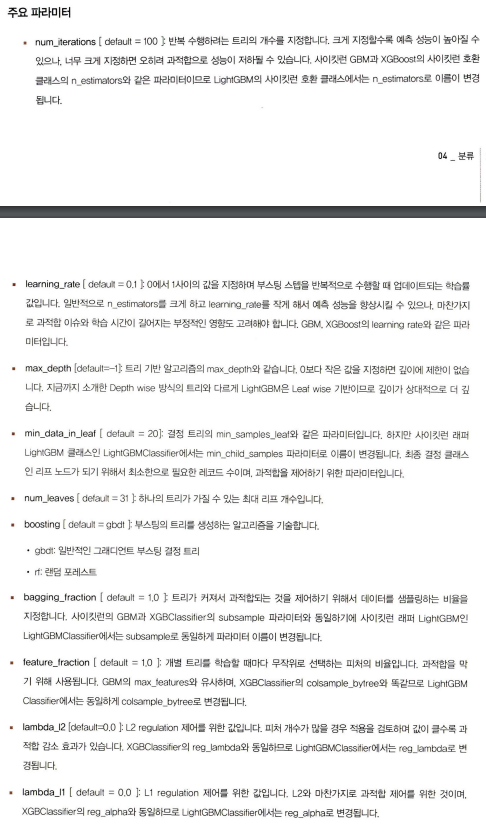

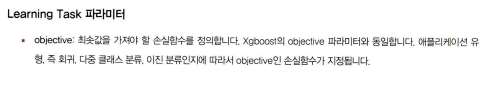



하이퍼 파라미터 튜닝 방안
- num_leaves의 개수를 중심으로 min_child_samples(min_data_in_leaf), max_depth를 함께 조정하면서 모델의 복잡도를 줄이기

파이썬 래퍼 LightGBM과 사이킷런 래퍼 XGBoost, LightGBM 하이퍼 파라미터 비교
====================
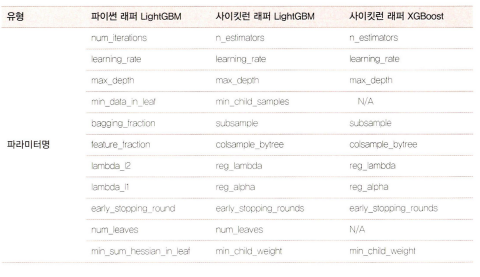

LightGBM 적용 - 위스콘신 유방암 예측
-------------------------------------------


In [ ]:
#LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

In [ ]:
# 80%는 학습용데이터 , 20%는 테스트용 데이터 추출 
X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size=0.2, random_state=156)

# 앞서 XGBoost와 동일하게 n_estmators는 400 설정
lgbm_wrapper = LGBMClassifier(n_estimators=400)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', 
                 eval_set=evals, verbose=True)
pred = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]

In [ ]:
# 예측 성능 평가
get_clf_eval(y_test, preds, pred_proba)

In [ ]:
# plot_importance()를 이용해 피처 중요도 시각화 : Column_0 : 첫번째 피처, Column_1 : 두번째 피처
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax=plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)

스태킹 앙상블 (pg.278)
============================
스태킹 앙상블
- 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측을 수행함
- 두 종류의 모델이 필요
  - 개별적인 기반 모델
  - 이 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습하는 최종 메타 모델
- 여러 개별 모델에 대한 예측 데이터를 각각 스태킹 형로 결합해, 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것

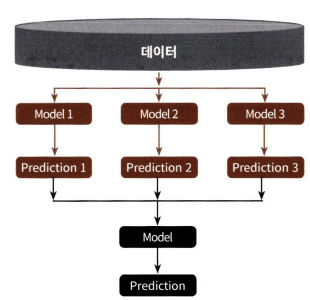

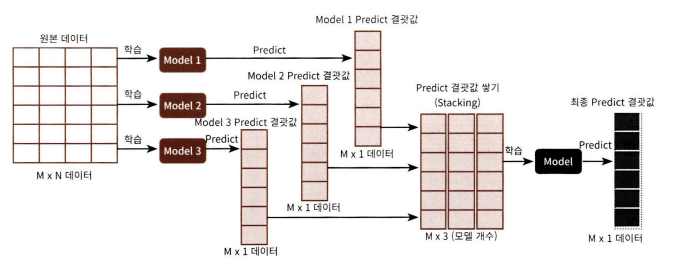

In [ ]:
# pg.280 : 기본 스태킹 모델

import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data=load_breast_cancer()
X_data=cancer_data.data
y_label=cancer_data.target

X_train, X_test, y_train, y_test=train_test_split(X_data, y_label, test_size=0.2, random_state=0)

In [ ]:
# 개별 ML 모델 생성
knn_clf=KNeighborsClassifier(n_neighbors=4)
rf_clf=RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf=DecisionTreeClassifier()
ada_clf=AdaBoostClassifier(n_estimators=100)

#스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final=LogisticRegression(C=10)

In [ ]:
# 개별 모델들을 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

In [ ]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정
knn_pred=knn_clf.predict(X_test)
rf_pred=rf_clf.predict(X_test)
dt_pred=dt_clf.predict(X_test)
ada_pred=ada_clf.predict(X_test)

print('KNN 정확도:{0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도:{0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도:{0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도:{0:.4f}'.format(accuracy_score(y_test, ada_pred)))

In [ ]:
pred=np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

#transpose를 이용해 행과 열의 위치 교환. 칼럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦
pred=np.transpose(pred)
print(pred.shape)

In [ ]:
# 최종 메타 모델인 로지스틱 회귀를 학습하고 예측 정확도 측정

lr_final.fit(pred, y_test)
final=lr_final.predict(pred)
print('최종 메타 모델의 예측 정확도:{0:.4f}'.format(accuracy_score(y_test, final)))

CV 세트 기반의 스태킹
----------------------------
- CV 세트 기반의 스태킹 모델은 과적합을 개선하기 위해 최종 메타 모델을 위한 데이터 세트를 만들 때 교차 검증 기반으로 예측된 결과 데이터 세트를 이용함

- 스텝 1 : 각 모델별로 원본 학습 / 테스트 데이터를 예측한 결과 값을 기반으로 메타 모델을 위한 학습용 / 테스트용 데이터를 생성함
- 스텝 2: 스텝 1에서 개별 모델들이 생성한 학습용 데이터를 모두 스태킹 형태로 합쳐서 메타 모델이 학습할 최종 학습용 데이터 세트를 생성함. 마찬가지로 각 모델들이 생성한 테스트용 데이터를 모두 스태킹 형태로 합쳐서 메타 모델이 예측할 최종 테스트 데이터 세트를 생성함. 메타 모델은 최종적으로 생성된 학습 데이터 세트와 원본 학습 데이터의 레이블 데이터를 기반으로 학습한 뒤, 최종적으로 생성된 테스트 데이터 세트를 예측하고, 원본 테스트 데이터의 레이블 데이터를 기반으로 평가함

1. 3개의 폴드만큼 반복을 수행하면서 스태킹 데이터를 생성하는 첫 번째 반복
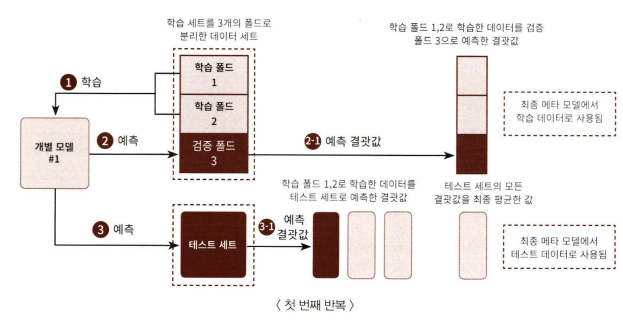

2. 스태킹 데이터를 생성하는 두 번째 반복. 폴드 내의 학습용 데이터 세트를 변경하고 첫 번째 그림과 동일한 작업 수행

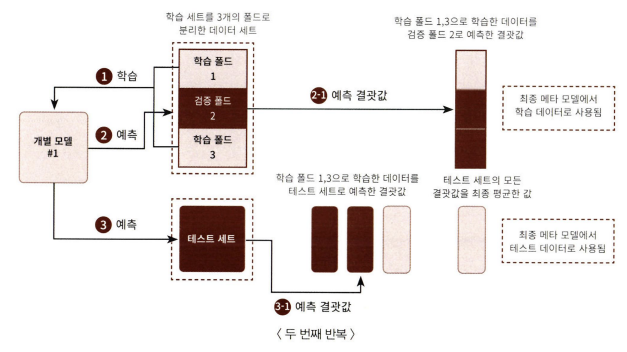

3. 스태킹 데이터를 생성하는 세 번째 반복. 세번째 반복을 수행하면서 폴드 내의 학습용 데이터 세트가 변경됨. 세번째 반복을 완료하면 첫번째, 두번째, 세번째 반복을 수행하면서 만들어진 폴드별 예측 데이터를 합하여 메타 모델에서 사용될 학습 데이터를 만들게 됨

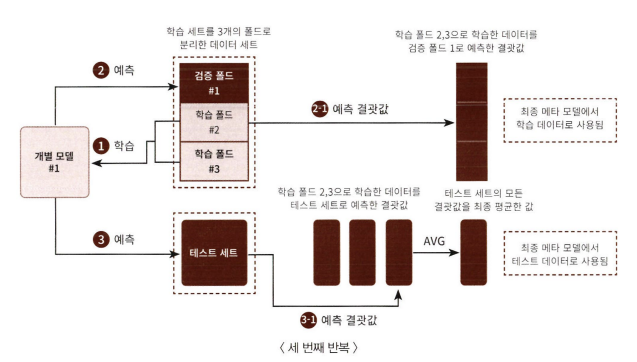

4. 각 모델들이 스텝 1로 생성한 학습과 테스트 데이터를 모두 합쳐서 최종적으로 메타 모델이 사용할 학습 데이터와 테스트 데이터를 생성하면 됨. 메타 모델이 사용할 최종 학습 데이터와 원본 데이터의 레이블 데이터를 합쳐서 메타 모델을 학습한 후에 최종 테스트 데이터로 예측을 수행한 뒤, 최종 예측 결과를 원본 테스트 데이터의 레이블 데이터와 비교해 평가

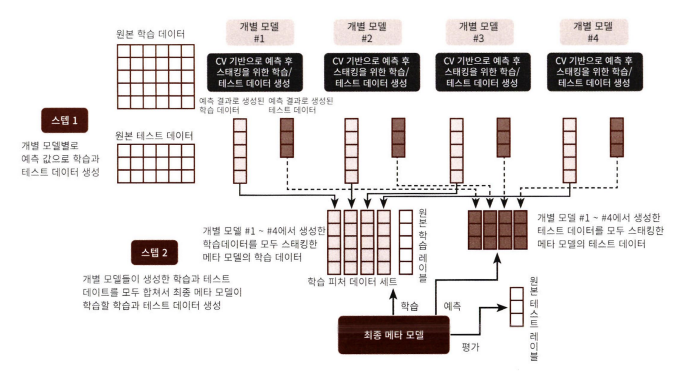


In [ ]:
# pg.286 : 스텝 1 코드 구현

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf=KFold(n_splits=n_folds, shuffle=True, random_state=0)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr=X_train_n[train_index] 
        y_tr=y_train_n[train_index] 
        X_te=X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :]=model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter]=model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean=np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [ ]:
knn_train, knn_test=get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test=get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test=get_stacking_base_datasets(dt_clf, X_train, y_train, X_test,  7)    
ada_train, ada_test=get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

In [ ]:
# 스텝 2 코드 구현

Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

In [ ]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))